# Setup function

## Requirements

### Inputs

<ul>
    <li>a complete path to a pandas dataframe (<b>file_path</b>)</li>
        <ul>
            <li>example dataframe used to test this function:</li>
                <ul><li>https://github.com/EpistasisLab/pmlb/raw/refs/heads/master/datasets/titanic/titanic.tsv.gz</li></ul>
        </ul>
    <li>the separator used in the data file - preceded by a backslash (<b>file_separator</b>):</li>
        <ul>
            <li>tab - \t (used to test this function)</li>
            <li>comma - \,</li>
            <li>semi-colon - \;</li>
            <li>colon - \:</li>
            <li>etc.</li>
        </ul>
    <li>the target to predict (<b>target_col</b>)</li>
        <ul>
            <li>target - used to test this function</li>
        </ul>
</ul>


The main code to start all parts looks like this:

*train_evaluate(dataframe, target_col)*

but other parts of the function require the file separator (file_separator) as well, in order to properly read in the file.



### Outputs

<ul>
    <li>Model Name</li>
    <li>Accuracy Score</li>
    <li>MSE score</li>
    <li>Graphs comparing Accuracy and MSE scores</li>
</ul>

## Imports

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import sklearn.linear_model
import math
import sys
from IPython.display import display, Javascript

# Body 

## Get user input and call read function

### Get user input

In [13]:
file_path = input("Full path to dataframe: ")
file_separator = input("Separator used in dataframe (i.e., tab): ")
target_col = input("Target feature in the dataframe (column name): ")

Full path to dataframe:  titanic
Separator used in dataframe (i.e., tab):  tab
Target feature in the dataframe (column name):  target


### Define read file function

In [15]:
def read_file(filepath=None, file_separator=None, target=None):

    # check for valid inputs and set defaults
    if filepath is None:
        print("Please provide a file path.")
        sys.exit(1)
    elif filepath.upper() == "TITANIC":
        filepath = "https://github.com/EpistasisLab/pmlb/raw/refs/heads/master/datasets/titanic/titanic.tsv.gz"
    
    if file_separator is None:  
        print("Please provide a file separator.")
        sys.exit(1)
    if file_separator.upper() == "T": 
        file_separator = "\t"
    elif file_separator.upper() == "C":
        file_separator = ","
    elif file_separator.upper() == "SPACE":
        file_separator = " "
    elif file_separator.upper() == "SEMICOLON":
        file_separator = ";"
    elif file_separator.upper() == "TAB":
        file_separator = "\t"
    elif file_separator.upper() == "PIPE":
        file_separator = "|"
    elif file_separator.upper() == "COLON":
        file_separator = ":"
    elif file_separator.upper() == "NONE":
        file_separator = None
    elif file_separator.upper() == "OTHER":
        file_separator = input("Please provide a custom file separator: ")
     

    if target is None:
        print("Please provide a target variable.")
        sys.exit(1)

    # read the file
    df = pd.read_csv(filepath, sep=file_separator, engine='python')
    df_new = df.dropna()

    # dataframe = df_new
    # split dataset into features and target
    df_features = df_new.drop(columns=[target])
    df_target = df_new[target]
    
    return df_new, df_features, df_target

### Call read function

In [17]:
# Call the read_file function with variables
dataframe, features, target_values = read_file(
    file_path,
    file_separator,
    target_col
)

## Define other functions

### Plot and Compare function

In [20]:
def plot_to_compare(model_name1, score1, mse1, model_name2, score2, mse2, model_name3, score3, mse3, model_name4, score4, mse4):
    
    print(f"\n\n\033[1mThis can be plotted with the following results:\033[0m\n")
    
    models = [model_name1, model_name2, model_name3, model_name4]
    scores = [score1, score2, score3, score4]
    mse_scores = [mse1, mse2, mse3, mse4]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

    bars1 = ax1.bar(models, mse_scores, color=['skyblue', 'orange', 'green', 'red'])
    for bar, score in zip(bars1, mse_scores):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f'{score:.4f}', ha='center', va='bottom', fontsize=8)
    ax1.set_title('Model Mean Squared Error (LOWER IS BETTER)')
    ax1.set_ylabel('MSE')
    ax1.set_ylim(0, max(mse_scores) * 1.1)
    ax1.grid(axis='y', linestyle='--', alpha=0.7)

    bars2 = ax2.bar(models, scores, color=['skyblue', 'orange', 'green', 'red'])
    for bar, score in zip(bars2, scores):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f'{score:.4f}', ha='center', va='bottom', fontsize=8)
    ax2.set_title('Model Accuracy (HIGHER IS BETTER)')
    ax2.set_ylabel('Accuracy')
    ax2.set_ylim(0, max(scores) * 1.1)
    ax2.grid(axis='y', linestyle='--', alpha=0.7)

    for ax in (ax1, ax2):
        ax.set_xticks(range(len(models)))
        ax.set_xticklabels(models, rotation=15)

    plt.tight_layout()
    plt.show()
    plt.close()

    return

### train and evaluate function

In [22]:
def train_and_evaluate_model(model_type, model_name_str, X_train, X_test, y_train, y_test):
    
    from sklearn.metrics import mean_squared_error

    model = model_type
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = model.score(X_test, y_test)
    mse = mean_squared_error(y_test, y_pred)

    print(f"Model:\033[1m{model_name_str:<24}\033[0m\tAccuracy Score:\t\033[1m{score:.4f}\033[0m\tMSE Score:\t\033[1m{mse:.4f}\033[0m")
    
    return model_name_str, score, mse

### train it function

In [24]:
def train_evaluate(data, target):
    from sklearn.model_selection import train_test_split
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.linear_model import LogisticRegression, Ridge
    from sklearn.svm import LinearSVC

    y = data[target].copy()
    X = data.drop(columns=[target])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Call the train and evaluate model function for each model
    
    model_name1, score1, mse1 = train_and_evaluate_model(LogisticRegression(penalty='l2', max_iter=1000), 'Logistic Regression', X_train, X_test, y_train, y_test)
    model_name2, score2, mse2 = train_and_evaluate_model(LinearSVC(penalty='l2', max_iter=1000), 'Linear SVC', X_train, X_test, y_train, y_test)
    model_name3, score3, mse3 = train_and_evaluate_model(Ridge(alpha=1.0, max_iter=1000), 'Ridge', X_train, X_test, y_train, y_test)
    model_name4, score4, mse4 = train_and_evaluate_model(RandomForestClassifier(n_estimators=7, max_depth=7), 'Random Forest Classifier', X_train, X_test, y_train, y_test)

    # Call the plot function with the results from the train and evaluate function

    plot_to_compare(model_name1, score1, mse1, model_name2, score2, mse2, model_name3, score3, mse3, model_name4, score4, mse4)

    return



# Call Main function

Model:Logistic Regression     	Accuracy Score:	0.7952	MSE Score:	0.2048
Model:Linear SVC              	Accuracy Score:	0.7952	MSE Score:	0.2048
Model:Ridge                   	Accuracy Score:	0.2670	MSE Score:	0.1549
Model:Random Forest Classifier	Accuracy Score:	0.8063	MSE Score:	0.1937


This can be plotted with the following results:



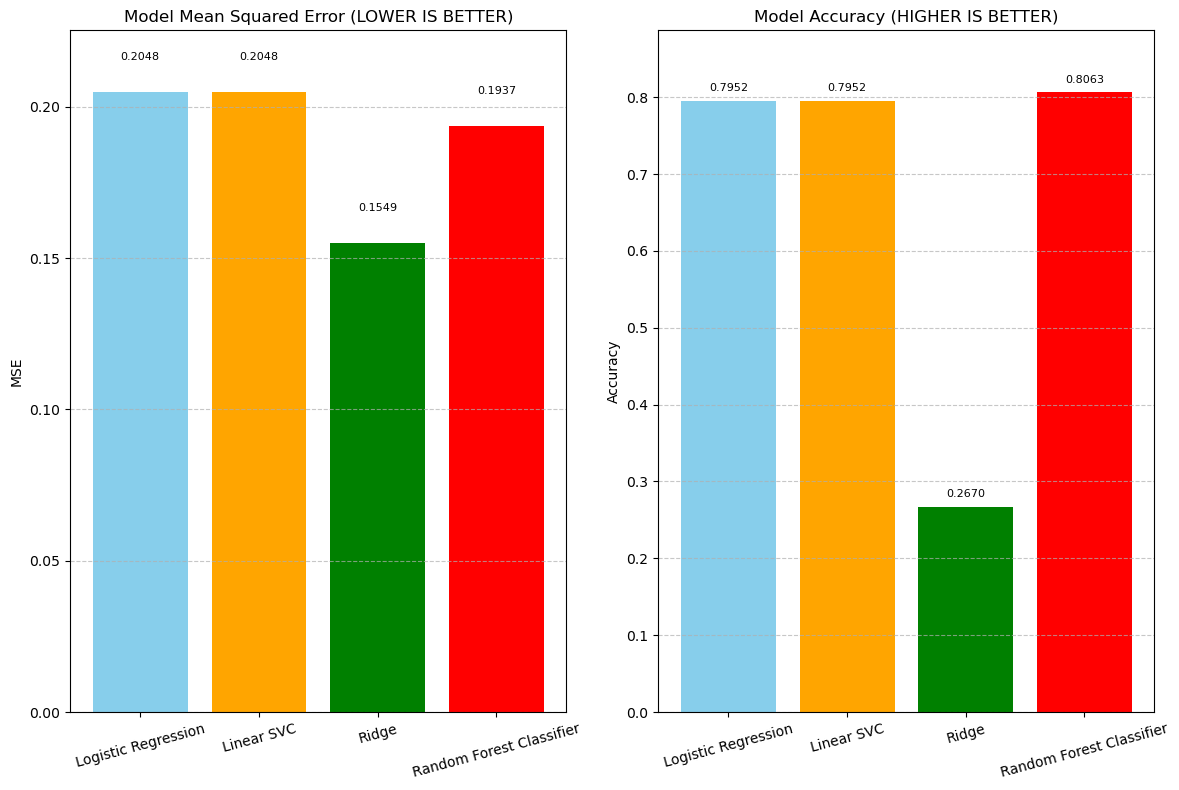

In [26]:
train_evaluate(dataframe, target_col)